In [351]:
import numpy as np
import pandas as pd
import datetime 


In [352]:
#data prep
p1 = r'C:\Users\kunal.mishra\Downloads\NQH25-CME-BarStudyData.csv'

df_1m = pd.read_csv(p1)
df_1m.columns = df_1m.columns.str.strip()
df_1m['Timestamp'] = pd.to_datetime(df_1m['Date'] + ' ' + df_1m['Time'])
df_1m.set_index(df_1m['Timestamp'],inplace=True)

df_1m.drop(columns = ['Date','Time'], inplace = True)
df_1m.drop(columns = df_1m.columns[-9:],axis = 1, inplace = True) #dropping irrelevant columns 

df_1m.dropna(inplace=True)
print(df_1m.head())

#data chunk
start_date = pd.to_datetime('03-01-2022')
#df_1m = df_1m[df_1m.index >= start_date]

df_5m = df_1m.resample('5min').aggregate({
    'Open':'first',
    'High':'max',
    'Low':'min',
    'Last':'last'
})
df_15m = df_1m.resample('15min').aggregate({
    'Open':'first',
    'High':'max',
    'Low':'min',
    'Last':'last'
})

df_5m.dropna(inplace=True)
df_15m.dropna(inplace=True)


                        Open     High      Low     Last  Volume
Timestamp                                                      
2009-11-27 03:26:00  3756.25  3756.50  3756.25  3756.50       4
2009-11-27 04:54:00  3750.50  3750.50  3750.50  3750.50       1
2009-11-27 05:00:00  3746.50  3748.75  3745.25  3745.25      10
2009-11-27 05:48:00  3740.75  3740.75  3740.75  3740.75       1
2009-11-27 06:19:00  3742.00  3742.00  3742.00  3742.00       1


In [353]:
# range formation

NrmlOpenTime = datetime.time(15,30)
NrmlClose = datetime.time(15,45)
Nrml_mkt_close = datetime.time(22,00)

DaylightOpenTime = datetime.time(14,30)
DaylightClose = datetime.time(14,45)
dls_mkt_close = datetime.time(21,00)

NrmlMonth = list(range(3,11))
DaylightMonth = [11,12,1,2]

    #data drop prior to US open 
df_5m = df_5m[((df_5m.index.month.isin(NrmlMonth)) & (df_5m.index.time >= NrmlOpenTime) & (df_5m.index.time <= Nrml_mkt_close)) | ((df_5m.index.month.isin(DaylightMonth)) & (df_5m.index.time >= DaylightOpenTime) & (df_5m.index.time <= dls_mkt_close))]  

range_mask_nrml = ((df_5m.index.month.isin(NrmlMonth)) & ((df_5m.index.time >= NrmlOpenTime) & (df_5m.index.time <= NrmlClose)))
range_mask_dayLight = ((df_5m.index.month.isin(DaylightMonth)) & ((df_5m.index.time >= DaylightOpenTime) & (df_5m.index.time <= DaylightClose)))
range_final = range_mask_nrml | range_mask_dayLight


df_5m.loc[range_final,'Range High'] = df_5m.loc[range_final].groupby(df_5m.loc[range_final].index.date)['High'].transform('max')
df_5m.loc[range_final,'Range Low'] =  df_5m.loc[range_final].groupby(df_5m.loc[range_final].index.date)['Low'].transform('min')

df_5m['Range High'] = df_5m.groupby(df_5m.index.date)['Range High'].ffill()
df_5m['Range Low'] = df_5m.groupby(df_5m.index.date)['Range Low'].ffill()
df_5m.dropna(inplace=True)
df_5m.reset_index(inplace=True)
print(df_5m.head())

            Timestamp     Open     High      Low     Last  Range High  \
0 2009-11-27 14:30:00  3750.25  3753.00  3746.25  3753.00      3763.0   
1 2009-11-27 14:35:00  3755.50  3756.50  3755.50  3756.50      3763.0   
2 2009-11-27 14:40:00  3756.75  3763.00  3756.75  3763.00      3763.0   
3 2009-11-27 14:45:00  3757.75  3758.00  3757.75  3758.00      3763.0   
4 2009-11-27 14:50:00  3761.75  3761.75  3761.75  3761.75      3763.0   

   Range Low  
0    3746.25  
1    3746.25  
2    3746.25  
3    3746.25  
4    3746.25  


In [354]:
#removing missing data
df_5m['Date'] = df_5m['Timestamp'].dt.date
df_5m = df_5m.groupby('Date').filter(lambda x: len(x)>40)
df_5m.reset_index(inplace = True)
df_5m.head()
# missing_date = pd.to_datetime('03-09-2022')
# df_5m = df_5m[df_5m['Timestamp'].dt.date!=missing_date.date()]
# print(df_5m.at[217661,'Timestamp'].date(),df_5m.iloc[-1]['Timestamp'].date())

,index,Timestamp,Open,High,Low,Last,Range High,Range Low,Date
0,72,2009-12-01 14:30:00,3786.50,3791.75,3786.50,3789.25,3795.25,3786.5,2009-12-01
1,73,2009-12-01 14:35:00,3792.25,3793.25,3791.75,3793.25,3795.25,3786.5,2009-12-01
2,74,2009-12-01 14:40:00,3793.75,3794.75,3793.75,3794.00,3795.25,3786.5,2009-12-01
3,75,2009-12-01 14:45:00,3795.25,3795.25,3793.75,3794.75,3795.25,3786.5,2009-12-01
4,76,2009-12-01 14:50:00,3794.50,3795.25,3794.50,3795.25,3795.25,3786.5,2009-12-01


In [372]:
#trade analysis

df_5m['Entry'] = 0
df_5m['Exit'] = 0
df_5m['Entry Price'] = None
df_5m['Exit Price'] = None

tick_size = 0.25
tick_value = 0.5
lot_size = 4
tick_t = 1000*tick_size  # x ticks for SL

i = 0
c_per = 0.25 #cascade percent of original position
c_count = 10#no. of cascades
candle_check = 3 #candles for cascade range
while i < len(df_5m):

    current_day = df_5m.at[i,'Timestamp'].date()
    #current_price = df_5m.at[i,'Last']
    range_high = df_5m.at[i,'Range High']
    range_low = df_5m.at[i,'Range Low']

    tp_short = range_high - tick_t
    tp_long = range_low + tick_t

    #lot_size = round((risk_per_trade)/(((range_high - range_low) / tick_size)*tick_value))

    high_break = df_5m.at[i,'High'] > range_high
    low_break = df_5m.at[i,'Low'] < range_low

    last_day = df_5m.iloc[-1]['Timestamp'].date()
    
    if current_day == last_day:
        break
    
    j=0     #j-1 is the no. of candles after which we cascade/pyramid
    c=0     #cascades count
    if high_break:
        df_5m.at[i,'Entry'] = -1*lot_size
        df_5m.at[i,'Entry Price'] = range_high + 0.25
        pos = -1*lot_size
        trade_day = current_day
        i = i+1
        while trade_day == current_day:

            if df_5m.at[i,'Low'] <= tp_short:
                df_5m.at[i,'Exit'] = -1*pos
                df_5m.at[i,'Exit Price'] = tp_short
                while (trade_day == current_day):
                    i+=1
                    trade_day = df_5m.at[i,'Timestamp'].date()
                break
            
            
            if (c<c_count) and (j>=candle_check) and (df_5m.at[i,'High']>df_5m.iloc[i-candle_check:i]['High'].max()):
                add = int(pos*c_per)
                df_5m.at[i,'Entry'] = 1*add
                df_5m.at[i,'Entry Price'] = df_5m.iloc[i-candle_check:i]['High'].max() + 0.25
                pos += 1*add
                j=0
                c+=1
                tp_short = df_5m.iloc[i-candle_check:i]['Low'].min()
            
            i+=1
            j+=1
        
            trade_day = df_5m.at[i,'Timestamp'].date()
            if trade_day != current_day:
                df_5m.at[i-1,'Exit'] = -1*pos
                df_5m.at[i-1,'Exit Price'] = df_5m.at[i-1,'Last']

    elif low_break:
        df_5m.at[i,'Entry'] = 1*lot_size
        df_5m.at[i,'Entry Price'] = range_low - 0.25
        pos = 1*lot_size
        trade_day = current_day
        i = i+1
        while trade_day == current_day:

            if df_5m.at[i,'High'] >= tp_long:
                df_5m.at[i,'Exit'] = -1*pos
                df_5m.at[i,'Exit Price'] = tp_long 
                while (trade_day == current_day):
                    i+=1
                    trade_day = df_5m.at[i,'Timestamp'].date()
                break
            
            
            if (c<c_count) and (j>=candle_check) and (df_5m.at[i,'Low']<df_5m.iloc[i-candle_check:i]['Low'].min()):
                add = int(pos*c_per)
                df_5m.at[i,'Entry'] = 1*add
                df_5m.at[i,'Entry Price'] = df_5m.iloc[i-candle_check:i]['Low'].min() - 0.25
                pos += 1*add
                j=0
                c+=1
                tp_long = df_5m.iloc[i-candle_check:i]['High'].max()

            i+=1
            j+=1
            
            trade_day = df_5m.at[i,'Timestamp'].date()
            if trade_day!=current_day:
                df_5m.at[i-1,'Exit'] = -1*pos
                df_5m.at[i-1,'Exit Price'] = df_5m.at[i-1,'Last']


    i+=1


In [373]:
#trade stats
rt_cost = 1

df_5m_entry = df_5m.loc[df_5m['Entry']!=0,['Timestamp','Entry','Entry Price']] 
df_5m_entry.set_index(df_5m_entry['Timestamp'],inplace = True)
df_5m_entry = df_5m_entry.resample('1d').aggregate({
    'Entry':'sum',
    'Entry Price':'mean'
})
df_5m_entry.dropna(inplace=True)
df_5m_entry.reset_index(inplace=True)
df_5m_entry.rename(columns={'Timestamp':'Entry Time'},inplace  =True)
df_5m_exit = df_5m.loc[df_5m['Exit']!=0,['Timestamp','Exit','Exit Price']] 
df_5m_exit.rename(columns={'Timestamp':'Exit Time'},inplace  =True)
#print(df_5m_entry.shape[0], df_5m_exit.shape[0])
df_5m_entry.reset_index(drop = True, inplace = True)
df_5m_exit.reset_index(drop = True, inplace = True)
df_stats = pd.concat([df_5m_entry,df_5m_exit], axis = 1)

df_stats['Total Trades'] = df_stats.shape[0]
df_stats['Gross($)'] = ((df_stats['Exit']*(df_stats['Entry Price'] - df_stats['Exit Price'])) / tick_size)*tick_value
df_stats['Cost'] = abs(df_stats['Entry'])*rt_cost
df_stats['Net($)'] = df_stats['Gross($)'] - df_stats['Cost']
df_stats['Cummulative'] = df_stats['Net($)'].cumsum()

print(f"Gross Pnl  = {df_stats['Gross($)'].sum()}")
print(f"Cummulative Pnl  = {df_stats['Net($)'].sum()}")
print(f"Hit ratio = {(df_stats['Net($)']>0).sum() / df_stats['Net($)'].count():.2f}")
print(f"AVerage RR = {df_stats.loc[df_stats['Gross($)']>0,'Gross($)'].sum() / abs(df_stats.loc[df_stats['Gross($)']<0,'Gross($)'].sum()):.2f}")
print(f"Intraday Pnl Std dev  = {df_stats['Net($)'].std():.2f}")
print(f"Trade Freq = {df_stats.shape[0] / len((df_5m['Timestamp'].dt.date).unique())}")
print(f"Sharpe = {df_stats['Net($)'].mean()/df_stats['Net($)'].std()} \n")
df_stats['Date'] = df_stats['Entry Time'].dt.year
#print(f"{df_stats.groupby('Date')['Net($)'].sum()}")
#print(f"{df_stats.groupby('Date').count()}")
# print(type(df_stats['Gross($)'].dtype))
#print(f"{df_stats['Net($)'].nlargest(3)}")
#print(f"{df_stats['Net($)'].nsmallest(3)}")

Gross Pnl  = 29793.224025974105
Cummulative Pnl  = 3225.224025974112
Hit ratio = 0.72
AVerage RR = 1.08
Intraday Pnl Std dev  = 587.40
Trade Freq = 0.9981303418803419
Sharpe = 0.0014692682655949082 



Text(0, 0.5, 'Cum PnL')

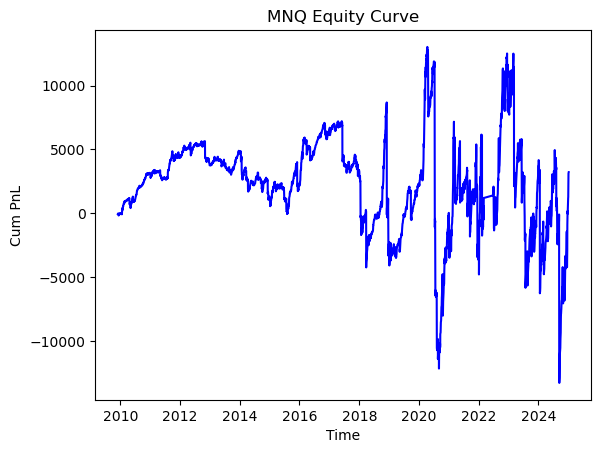

In [374]:
import matplotlib.pyplot as plt

plt.plot(df_stats['Entry Time'].dt.date,df_stats['Cummulative'],color = 'blue')
plt.title('MNQ Equity Curve')
plt.xlabel('Time')
plt.ylabel('Cum PnL')